In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder # LabelEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

train = pd.read_csv('./dataset/train_df.csv', encoding='cp949')
test  = pd.read_csv('./dataset/test_df.csv', encoding='cp949')
sub   = pd.read_csv('./dataset/sample_submission.csv', encoding='cp949')

In [2]:
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9
3,3,1154500002014200,5011000315087400,식품,농산물,10
4,4,1165000021008300,5011000177051200,식품,가공식품,3


In [3]:
test.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,32000,5013000043028400,1165000021097200,식품,농산물
1,32001,5013000044016100,1154500002066400,식품,농산물
2,32002,5013000205030200,4139000102013200,식품,농산물
3,32003,5013000205030200,4221000040093400,식품,농산물
4,32004,5013000268011400,2726000004017100,식품,농산물


In [4]:
train.shape, test.shape, sub.shape

((32000, 6), (4640, 5), (4640, 2))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          32000 non-null  int64 
 1   SEND_SPG_INNB  32000 non-null  int64 
 2   REC_SPG_INNB   32000 non-null  int64 
 3   DL_GD_LCLS_NM  32000 non-null  object
 4   DL_GD_MCLS_NM  32000 non-null  object
 5   INVC_CONT      32000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.5+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          4640 non-null   int64 
 1   SEND_SPG_INNB  4640 non-null   int64 
 2   REC_SPG_INNB   4640 non-null   int64 
 3   DL_GD_LCLS_NM  4640 non-null   object
 4   DL_GD_MCLS_NM  4640 non-null   object
dtypes: int64(3), object(2)
memory usage: 181.4+ KB


# 데이터 전처리

<AxesSubplot:xlabel='SEND_SPG_INNB', ylabel='Density'>

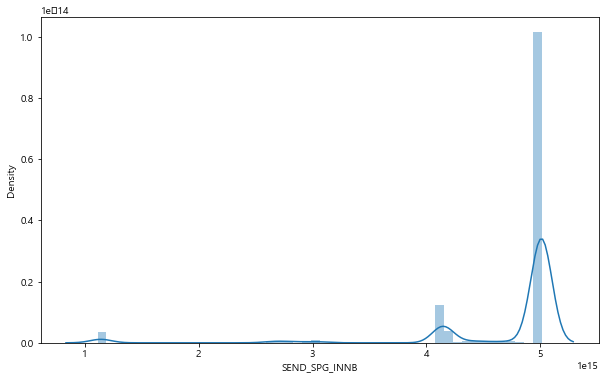

In [7]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["SEND_SPG_INNB"])

Skewness: -4.561
Kurtosis: 21.404


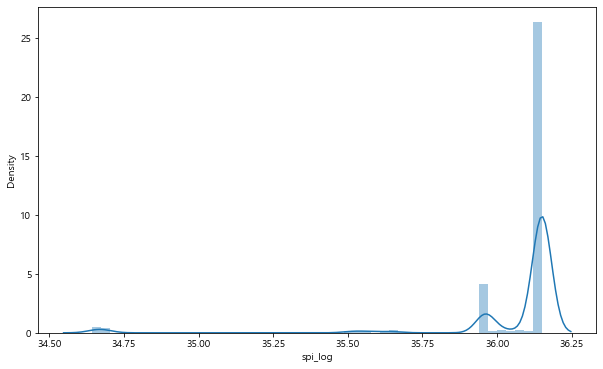

In [8]:
train["spi_log"] = np.log1p(train["SEND_SPG_INNB"]) 
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["spi_log"]) 
print("Skewness: {:.3f}".format(train["spi_log"].skew()))
print("Kurtosis: {:.3f}".format(train["spi_log"].kurt()))

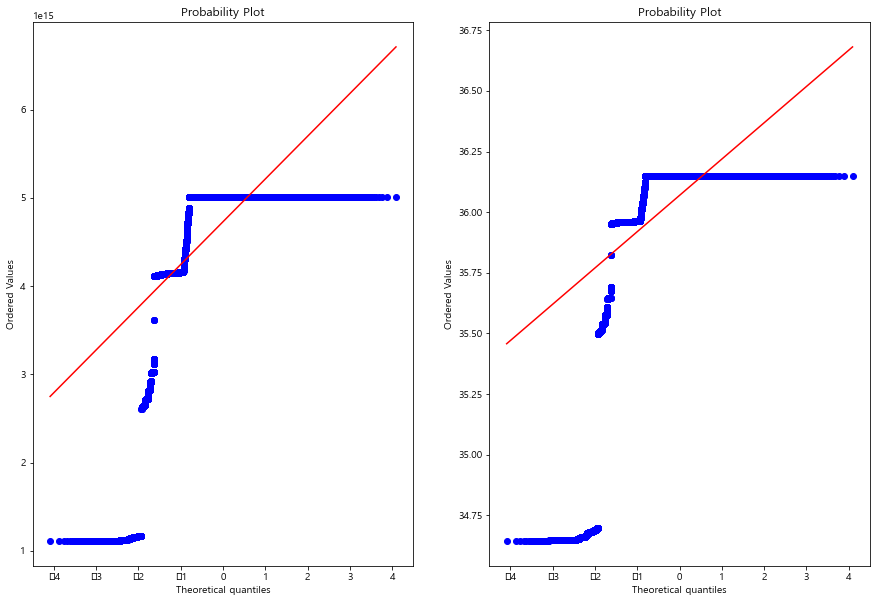

In [9]:
from scipy import stats 
fig = plt.figure(figsize = (15,10)) 
fig.add_subplot(1,2,1) 
res = stats.probplot(train['SEND_SPG_INNB'], plot=plt)
fig.add_subplot(1,2,2) 
res = stats.probplot(train['spi_log'], plot=plt)

In [10]:
train.drop('spi_log', axis=1, inplace= True)

## 격자고유번호 선별

In [11]:
train['SEND_SPG_INNB'].head(35) # 11:5, 9:7, 7:4:5, 10:6, 2:3:3:2:6

0     1129000014045300
1     1135000009051200
2     1135000030093100
3     1154500002014200
4     1165000021008300
5     1168000013091300
6     1171000019003100
7     2623000012072300
8     2626000011052400
9     2726000034007300
10    2729000029060300
11    2811000069044300
12    2820000053057300
13    2914000013007300
14    3023000012008100
15    3023000012008100
16    3023000012008100
17    4111300037051300
18    4119900009063300
19    4119900009063300
20    4119900009063300
21    4121000015010300
22    4121000015010300
23    4122000151090400
24    4127300065073100
25    4128500028049400
26    4136000185087300
27    4136000216029100
28    4136000216029100
29    4136000216029100
30    4136000216029100
31    4141000031009400
32    4141000031030100
33    4141000031030100
34    4141000031030100
Name: SEND_SPG_INNB, dtype: int64

In [12]:
for df in [train, test]:
    df['rpi_1'] = df["REC_SPG_INNB"].astype('str').str[:1]
    df['spi_1'] = df["SEND_SPG_INNB"].astype('str').str[:1]

    df['rpi_2'] = df["REC_SPG_INNB"].astype('str').str[:2]
    df['spi_2'] = df["SEND_SPG_INNB"].astype('str').str[:2]

    df['rpi_3'] = df["REC_SPG_INNB"].astype('str').str[:3]
    df['spi_3'] = df["SEND_SPG_INNB"].astype('str').str[:3]

    df['rpi_4'] = df["REC_SPG_INNB"].astype('str').str[:4]
    df['spi_4'] = df["SEND_SPG_INNB"].astype('str').str[:4]

    df['rpi_5'] = df["REC_SPG_INNB"].astype('str').str[:5]
    df['spi_5'] = df["SEND_SPG_INNB"].astype('str').str[:5]

    df['rpi_6'] = df["REC_SPG_INNB"].astype('str').str[:6]
    df['spi_6'] = df["SEND_SPG_INNB"].astype('str').str[:6]

    df['rpi_7'] = df["REC_SPG_INNB"].astype('str').str[:7]
    df['spi_7'] = df["SEND_SPG_INNB"].astype('str').str[:7]

    df['rpi_8'] = df["REC_SPG_INNB"].astype('str').str[:8]
    df['spi_8'] = df["SEND_SPG_INNB"].astype('str').str[:8]

    df['rpi_9'] = df["REC_SPG_INNB"].astype('str').str[:9]
    df['spi_9'] = df["SEND_SPG_INNB"].astype('str').str[:9]

    df['rpi_10'] = df["REC_SPG_INNB"].astype('str').str[:10]
    df['spi_10'] = df["SEND_SPG_INNB"].astype('str').str[:10]

    df['rpi_11'] = df["REC_SPG_INNB"].astype('str').str[:11]
    df['spi_11'] = df["SEND_SPG_INNB"].astype('str').str[:11]

    df['rpi_12'] = df["REC_SPG_INNB"].astype('str').str[:12]
    df['spi_12'] = df["SEND_SPG_INNB"].astype('str').str[:12]

    df['rpi_13'] = df["REC_SPG_INNB"].astype('str').str[:13]
    df['spi_13'] = df["SEND_SPG_INNB"].astype('str').str[:13]

    df['rpi_14'] = df["REC_SPG_INNB"].astype('str').str[:14]
    df['spi_14'] = df["SEND_SPG_INNB"].astype('str').str[:14]

    df['rpi_15'] = df["REC_SPG_INNB"].astype('str').str[:15]
    df['spi_15'] = df["SEND_SPG_INNB"].astype('str').str[:15]

    df['rpi_16'] = df["REC_SPG_INNB"].astype('str').str[:16]
    df['spi_16'] = df["SEND_SPG_INNB"].astype('str').str[:16]

In [13]:
spi_cols = ['spi_1', 'spi_2', 'spi_3', 'spi_4',
       'spi_5', 'spi_6', 'spi_7', 'spi_8', 'spi_9', 'spi_10', 'spi_11',
       'spi_12', 'spi_13', 'spi_14', 'spi_15', 'spi_16']
rpi_cols = ['rpi_1', 'rpi_2',
       'rpi_3', 'rpi_4', 'rpi_5', 'rpi_6', 'rpi_7', 'rpi_8', 'rpi_9', 'rpi_10',
       'rpi_11', 'rpi_12', 'rpi_13', 'rpi_14', 'rpi_15', 'rpi_16']

In [14]:
for col in spi_cols:
    print(col, train[col].nunique())

spi_1 5
spi_2 17
spi_3 64
spi_4 213
spi_5 234
spi_6 234
spi_7 240
spi_8 511
spi_9 1161
spi_10 2069
spi_11 2082
spi_12 3081
spi_13 3581
spi_14 3684
spi_15 3684
spi_16 3684


In [15]:
for col in rpi_cols:
    print(col, train[col].nunique())

rpi_1 5
rpi_2 17
rpi_3 65
rpi_4 229
rpi_5 251
rpi_6 251
rpi_7 268
rpi_8 979
rpi_9 3353
rpi_10 7739
rpi_11 7945
rpi_12 19039
rpi_13 26039
rpi_14 27826
rpi_15 27826
rpi_16 27826


#### unique 갯수가 20 이하인 격자번호 + unique 갯수가 비슷하거나 같은 격자번호는 제외

<pre>

<!-- spi_1 5
spi_2 17 -->
spi_3 64
spi_4 213
spi_5 234
<!-- spi_6 234 -->
spi_7 240
spi_8 511
spi_9 1161
<!-- spi_10 2069 -->
spi_11 2082
spi_12 3081
<!-- spi_13 3581 -->
spi_14 3684
<!-- spi_15 3684 -->
<!-- spi_16 3684 -->

<!-- rpi_1 5
rpi_2 17 -->
rpi_3 65
rpi_4 229
rpi_5 251
<!-- rpi_6 251 -->
rpi_7 268
rpi_8 979
rpi_9 3353
<!-- rpi_10 7739 -->
rpi_11 7945
rpi_12 19039
<!-- rpi_13 26039 -->
rpi_14 27826
<!-- rpi_15 27826 -->
<!-- rpi_16 27826 -->

</pre>

In [16]:
# 최종 선택 : 3, 4, 7, 8, 9, 11, 12, 14

train.drop(['spi_1', 'spi_2', 'spi_5', 'spi_6', 'spi_10', 'spi_13', 'spi_15', 'spi_16',
            'rpi_1', 'rpi_2', 'rpi_5', 'rpi_6', 'rpi_10', 'rpi_13', 'rpi_15', 'rpi_16'], axis=1, inplace= True)

test.drop(['spi_1', 'spi_2', 'spi_5', 'spi_6', 'spi_10', 'spi_13', 'spi_15', 'spi_16',
            'rpi_1', 'rpi_2', 'rpi_5', 'rpi_6', 'rpi_10', 'rpi_13', 'rpi_15', 'rpi_16'], axis=1, inplace= True)

In [17]:
obj_cols = ['spi_3', 'spi_4', 'spi_7', 'spi_8', 'spi_9', 'spi_11', 'spi_12', 'spi_14',
            'rpi_3', 'rpi_4', 'rpi_7', 'rpi_8', 'rpi_9', 'rpi_11', 'rpi_12', 'rpi_14']

for col in obj_cols:
    train[col] = train[col].astype('int64')

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          32000 non-null  int64 
 1   SEND_SPG_INNB  32000 non-null  int64 
 2   REC_SPG_INNB   32000 non-null  int64 
 3   DL_GD_LCLS_NM  32000 non-null  object
 4   DL_GD_MCLS_NM  32000 non-null  object
 5   INVC_CONT      32000 non-null  int64 
 6   rpi_3          32000 non-null  int64 
 7   spi_3          32000 non-null  int64 
 8   rpi_4          32000 non-null  int64 
 9   spi_4          32000 non-null  int64 
 10  rpi_7          32000 non-null  int64 
 11  spi_7          32000 non-null  int64 
 12  rpi_8          32000 non-null  int64 
 13  spi_8          32000 non-null  int64 
 14  rpi_9          32000 non-null  int64 
 15  spi_9          32000 non-null  int64 
 16  rpi_11         32000 non-null  int64 
 17  spi_11         32000 non-null  int64 
 18  rpi_12         32000 non-n

<AxesSubplot:>

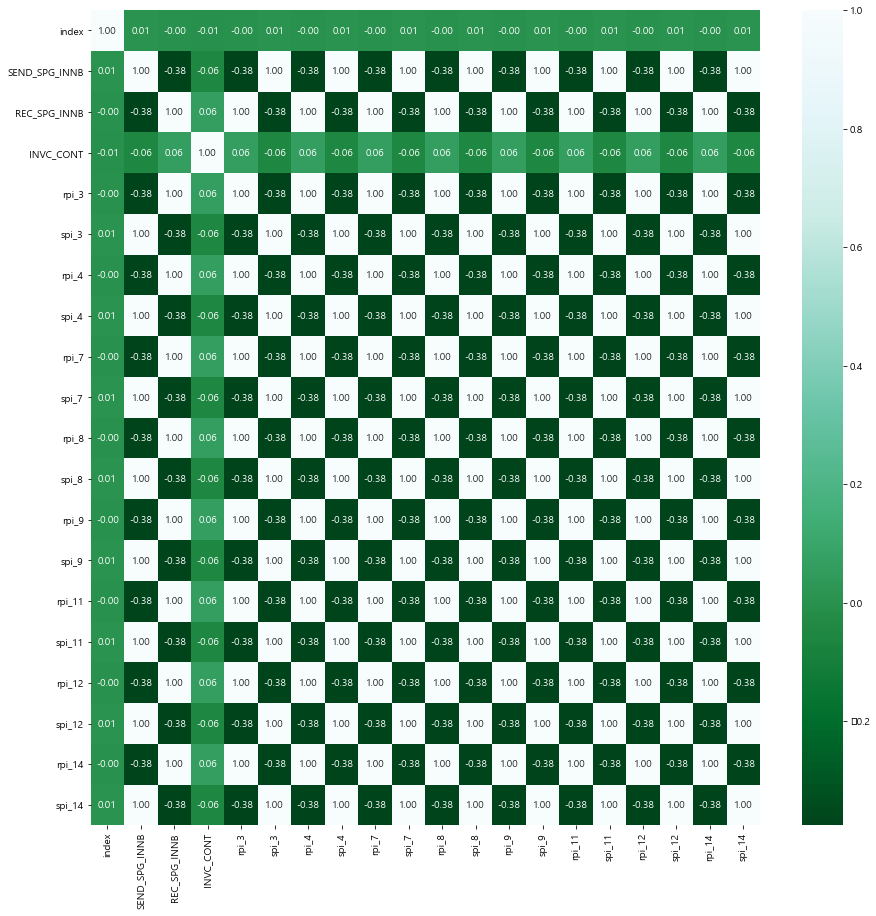

In [19]:
plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap= 'BuGn_r')

## 송하인, 수하인 고유격자번호가 같거나 다를때의 유통량 확인

In [20]:
train[train['SEND_SPG_INNB']==train['REC_SPG_INNB']]['INVC_CONT'].count()

37

In [21]:
train[train['SEND_SPG_INNB']!=train['REC_SPG_INNB']]['INVC_CONT'].count()

31963

In [22]:
# SEND_SPG_INNB != REC_SPG_INNB

idxs = train[train['SEND_SPG_INNB'] != train['REC_SPG_INNB']].index
train['not_same'] = 0

for idx in idxs:
    train.loc[idx, 'not_same'] = 1

idxs = test[test['SEND_SPG_INNB'] != test['REC_SPG_INNB']].index
test['not_same'] = 0

for idx in idxs:
    test.loc[idx, 'not_same'] = 1

## 제주도 간 물류 유통

In [23]:
train['spi_1'] = train["SEND_SPG_INNB"].astype('str').str[:1].astype('int64')
train['rpi_1'] = train["REC_SPG_INNB"].astype('str').str[:1].astype('int64')

test['spi_1'] = test["SEND_SPG_INNB"].astype('str').str[:1].astype('int64') 
test['rpi_1'] = test["REC_SPG_INNB"].astype('str').str[:1].astype('int64')

In [24]:
train['spi_2'] = train["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
train['rpi_2'] = train["REC_SPG_INNB"].astype('str').str[:2].astype('int64')

test['spi_2'] = test["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
test['rpi_2'] = test["REC_SPG_INNB"].astype('str').str[:2].astype('int64')

In [25]:
print(train[train['spi_1']==5][['spi_1', 'SEND_SPG_INNB']].shape)
print(train[train['spi_2']==50][['spi_2', 'SEND_SPG_INNB']].shape)
print(train[train['spi_3']==501][['spi_3', 'SEND_SPG_INNB']].shape) # 5: 제주도

(25344, 2)
(25344, 2)
(25344, 2)


In [26]:
jeju_idx = train[(train['spi_1'] == 5) & (train['rpi_1'] == 5)].index # ['INVC_CONT'].count()

train['jeju'] = 0

for idx in jeju_idx:
    train.loc[idx, 'jeju'] = 1

In [27]:
jeju_idx = test[(test['spi_1'] == 5) & (test['rpi_1'] == 5)].index # ['INVC_CONT'].count()

test['jeju'] = 0

for idx in jeju_idx:
    test.loc[idx, 'jeju'] = 1

In [28]:
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,rpi_3,spi_3,rpi_4,spi_4,rpi_7,spi_7,rpi_8,spi_8,rpi_9,spi_9,rpi_11,spi_11,rpi_12,spi_12,rpi_14,spi_14,not_same,spi_1,rpi_1,spi_2,rpi_2,jeju
0,0,1129000014045300,5011000220046300,패션의류,상의,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0
3,3,1154500002014200,5011000315087400,식품,농산물,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0
4,4,1165000021008300,5011000177051200,식품,가공식품,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0


## 유통수(count)가 가장 많은 spi_1 가중치

In [29]:
# 5
train.groupby('spi_1').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
spi_1,
5,25344
4,4984
1,859
2,550
3,263


In [30]:
train['spi_1_plus'] = 0
train.loc[train['spi_1']==5, 'spi_1_plus'] = 1

test['spi_1_plus'] = 0
test.loc[test['spi_1']==5, 'spi_1_plus'] = 1

In [31]:
# 4
train.groupby('rpi_1').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
rpi_1,
4,14260
5,6833
1,4984
2,4514
3,1409


In [32]:
train['rpi_1_plus'] = 0
train.loc[train['rpi_1']==4, 'rpi_1_plus'] = 1

test['rpi_1_plus'] = 0
test.loc[test['rpi_1']==4, 'rpi_1_plus'] = 1

## 유통수(count)가 가장 많은 중분류, 대분류에 가중치

In [33]:
# 중분류: 농산물
train.groupby('DL_GD_MCLS_NM').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
DL_GD_MCLS_NM,
농산물,22162
문화컨텐츠,1192
음료,1126
수산,931
가공식품,923
기타식품,766
건강식품,651
음반,635
축산,418


In [34]:
train['farm_plus'] = 0
train.loc[train['DL_GD_MCLS_NM'] == '농산물', 'farm_plus'] = 1
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,rpi_3,spi_3,rpi_4,spi_4,rpi_7,spi_7,rpi_8,spi_8,rpi_9,spi_9,rpi_11,spi_11,rpi_12,spi_12,rpi_14,spi_14,not_same,spi_1,rpi_1,spi_2,rpi_2,jeju,spi_1_plus,rpi_1_plus,farm_plus
0,0,1129000014045300,5011000220046300,패션의류,상의,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0
3,3,1154500002014200,5011000315087400,식품,농산물,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1
4,4,1165000021008300,5011000177051200,식품,가공식품,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0


In [35]:
test['farm_plus'] = 0
test.loc[test['DL_GD_MCLS_NM'] == '농산물', 'farm_plus'] = 1

In [36]:
# 대분류: 식품
train.groupby('DL_GD_LCLS_NM').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
DL_GD_LCLS_NM,
식품,27738
생활/건강,2020
여행/문화,1192
패션의류,582
디지털/가전,241
화장품/미용,227


In [37]:
train['food_plus'] = 0
train.loc[train['DL_GD_LCLS_NM'] == '식품', 'food_plus'] = 1
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,rpi_3,spi_3,rpi_4,spi_4,rpi_7,spi_7,rpi_8,spi_8,rpi_9,spi_9,rpi_11,spi_11,rpi_12,spi_12,rpi_14,spi_14,not_same,spi_1,rpi_1,spi_2,rpi_2,jeju,spi_1_plus,rpi_1_plus,farm_plus,food_plus
0,0,1129000014045300,5011000220046300,패션의류,상의,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0,0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0,0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0,0
3,3,1154500002014200,5011000315087400,식품,농산물,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1,1
4,4,1165000021008300,5011000177051200,식품,가공식품,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0,1


In [38]:
test['food_plus'] = 0
test.loc[test['DL_GD_LCLS_NM'] == '식품', 'food_plus'] = 1

## 중분류, 대분류 평균값(mean)

In [39]:
# 중분류
train.groupby('DL_GD_MCLS_NM').mean()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
DL_GD_MCLS_NM,
기타패션의류,10.375479
건강용품,10.238636
축산,8.196172
문구/사무용품,7.900000
가공식품,6.807151
기타디지털/가전,6.547718
기타식품,6.130548
건강식품,5.780338
과자,5.767241


In [40]:
mcls = train.groupby("DL_GD_MCLS_NM").mean()["INVC_CONT"].reset_index().sort_values('INVC_CONT', ascending=False)
mcls.rename(columns={'INVC_CONT':'mcls_mean'}, inplace=True )
mcls

,DL_GD_MCLS_NM,mcls_mean
6,기타패션의류,10.375479
2,건강용품,10.238636
19,축산,8.196172
9,문구/사무용품,7.900000
0,가공식품,6.807151
4,기타디지털/가전,6.547718
5,기타식품,6.130548
1,건강식품,5.780338
3,과자,5.767241
16,음료,5.745115


In [41]:
# 대분류
train.groupby('DL_GD_LCLS_NM').mean()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
DL_GD_LCLS_NM,
패션의류,6.678694
디지털/가전,6.547718
생활/건강,5.407921
여행/문화,4.958893
화장품/미용,4.682819
식품,4.658195


In [42]:
lcls = train.groupby("DL_GD_LCLS_NM").mean()["INVC_CONT"].reset_index().sort_values('INVC_CONT', ascending=False)
lcls.rename(columns={'INVC_CONT':'lcls_mean'}, inplace=True )
lcls

,DL_GD_LCLS_NM,lcls_mean
4,패션의류,6.678694
0,디지털/가전,6.547718
1,생활/건강,5.407921
3,여행/문화,4.958893
5,화장품/미용,4.682819
2,식품,4.658195


In [43]:
# merge
train = pd.merge(train, lcls, how = 'left', on='DL_GD_LCLS_NM') # 대분류
train = pd.merge(train, mcls, how = 'left', on='DL_GD_MCLS_NM') # 중분류
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,rpi_3,spi_3,rpi_4,spi_4,rpi_7,spi_7,rpi_8,spi_8,rpi_9,spi_9,rpi_11,spi_11,rpi_12,spi_12,rpi_14,spi_14,not_same,spi_1,rpi_1,spi_2,rpi_2,jeju,spi_1_plus,rpi_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,0,1129000014045300,5011000220046300,패션의류,상의,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0,0,6.678694,3.672897
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0,0,5.407921,4.444134
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0,0,6.678694,10.375479
3,3,1154500002014200,5011000315087400,식품,농산물,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1,1,4.658195,4.297401
4,4,1165000021008300,5011000177051200,식품,가공식품,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0,1,4.658195,6.807151


In [44]:
test = pd.merge(test, lcls, how = 'left', on='DL_GD_LCLS_NM') # 대분류
test = pd.merge(test, mcls, how = 'left', on='DL_GD_MCLS_NM') # 중분류
test.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,rpi_3,spi_3,rpi_4,spi_4,rpi_7,spi_7,rpi_8,spi_8,rpi_9,spi_9,rpi_11,spi_11,rpi_12,spi_12,rpi_14,spi_14,not_same,spi_1,rpi_1,spi_2,rpi_2,jeju,spi_1_plus,rpi_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,32000,5013000043028400,1165000021097200,식품,농산물,116,501,1165,5013,1165000,5013000,11650000,50130000,116500002,501300004,11650000210,50130000430,116500002109,501300004302,11650000210972,50130000430284,1,5,1,50,11,0,1,0,1,1,4.658195,4.297401
1,32001,5013000044016100,1154500002066400,식품,농산물,115,501,1154,5013,1154500,5013000,11545000,50130000,115450000,501300004,11545000020,50130000440,115450000206,501300004401,11545000020664,50130000440161,1,5,1,50,11,0,1,0,1,1,4.658195,4.297401
2,32002,5013000205030200,4139000102013200,식품,농산물,413,501,4139,5013,4139000,5013000,41390001,50130002,413900010,501300020,41390001020,50130002050,413900010201,501300020503,41390001020132,50130002050302,1,5,4,50,41,0,1,1,1,1,4.658195,4.297401
3,32003,5013000205030200,4221000040093400,식품,농산물,422,501,4221,5013,4221000,5013000,42210000,50130002,422100004,501300020,42210000400,50130002050,422100004009,501300020503,42210000400934,50130002050302,1,5,4,50,42,0,1,1,1,1,4.658195,4.297401
4,32004,5013000268011400,2726000004017100,식품,농산물,272,501,2726,5013,2726000,5013000,27260000,50130002,272600000,501300026,27260000040,50130002680,272600000401,501300026801,27260000040171,50130002680114,1,5,2,50,27,0,1,0,1,1,4.658195,4.297401


In [45]:
# 반올림

train['lcls_mean'] = np.round(train['lcls_mean'], 0).astype('int64')
test['lcls_mean'] = np.round(test['lcls_mean'], 0).astype('int64')

train['mcls_mean'] = np.round(train['mcls_mean'], 0).astype('int64')
test['mcls_mean'] = np.round(test['mcls_mean'], 0).astype('int64')

In [46]:
train.head(15)

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,rpi_3,spi_3,rpi_4,spi_4,rpi_7,spi_7,rpi_8,spi_8,rpi_9,spi_9,rpi_11,spi_11,rpi_12,spi_12,rpi_14,spi_14,not_same,spi_1,rpi_1,spi_2,rpi_2,jeju,spi_1_plus,rpi_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,0,1129000014045300,5011000220046300,패션의류,상의,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0,0,7,4
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0,0,5,4
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0,0,7,10
3,3,1154500002014200,5011000315087400,식품,농산물,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1,1,5,4
4,4,1165000021008300,5011000177051200,식품,가공식품,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0,1,5,7
5,5,1168000013091300,5011000431068400,화장품/미용,스킨케어,5,501,116,5011,1168,5011000,1168000,50110004,11680000,501100043,116800001,50110004310,11680000130,501100043106,116800001309,50110004310684,11680000130913,1,1,5,11,50,0,0,0,0,0,5,5
6,6,1171000019003100,5011000439051200,식품,농산물,5,501,117,5011,1171,5011000,1171000,50110004,11710000,501100043,117100001,50110004390,11710000190,501100043905,117100001900,50110004390512,11710000190031,1,1,5,11,50,0,0,0,1,1,5,4
7,7,2623000012072300,5011000683013300,패션의류,기타패션의류,5,501,262,5011,2623,5011000,2623000,50110006,26230000,501100068,262300001,50110006830,26230000120,501100068301,262300001207,50110006830133,26230000120723,1,2,5,26,50,0,0,0,0,0,7,10
8,8,2626000011052400,5011000374047100,식품,가공식품,3,501,262,5011,2626,5011000,2626000,50110003,26260000,501100037,262600001,50110003740,26260000110,501100037404,262600001105,50110003740471,26260000110524,1,2,5,26,50,0,0,0,0,1,5,7
9,9,2726000034007300,5011000378006100,식품,기타식품,3,501,272,5011,2726,5011000,2726000,50110003,27260000,501100037,272600003,50110003780,27260000340,501100037800,272600003400,50110003780061,27260000340073,1,2,5,27,50,0,0,0,0,1,5,6


# Drop

In [47]:
train.drop(['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'DL_GD_LCLS_NM', 'index', 'spi_1', 'spi_2', 'rpi_1', 'rpi_2'], axis=1, inplace=True)
test.drop(['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'DL_GD_LCLS_NM', 'index', 'spi_1', 'spi_2', 'rpi_1', 'rpi_2'], axis=1, inplace=True) 

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   INVC_CONT   32000 non-null  int64
 1   rpi_3       32000 non-null  int64
 2   spi_3       32000 non-null  int64
 3   rpi_4       32000 non-null  int64
 4   spi_4       32000 non-null  int64
 5   rpi_7       32000 non-null  int64
 6   spi_7       32000 non-null  int64
 7   rpi_8       32000 non-null  int64
 8   spi_8       32000 non-null  int64
 9   rpi_9       32000 non-null  int64
 10  spi_9       32000 non-null  int64
 11  rpi_11      32000 non-null  int64
 12  spi_11      32000 non-null  int64
 13  rpi_12      32000 non-null  int64
 14  spi_12      32000 non-null  int64
 15  rpi_14      32000 non-null  int64
 16  spi_14      32000 non-null  int64
 17  not_same    32000 non-null  int64
 18  jeju        32000 non-null  int64
 19  spi_1_plus  32000 non-null  int64
 20  rpi_1_plus  32000 non-null  

# 인코딩

In [49]:
obj_cols = []
for col in train.columns:
    if train[col].dtype == 'object':
        obj_cols.append(col)

print(obj_cols)

[]


In [50]:
# encoder = OrdinalEncoder()
# train[['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']] = encoder.fit_transform(train[['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']])

# train = pd.get_dummies(train)
# test  = pd.get_dummies(test)

In [51]:
# train.head()

In [52]:
# plt.subplots(figsize=(10,10))
# sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap= 'BuGn_r')

# 모델링

In [53]:
# !pip install catboost

In [61]:
X = train.drop('INVC_CONT',axis = 1)
y = train['INVC_CONT']

grid = GridSearchCV(
    estimator= CatBoostRegressor(random_state= 35), param_grid= {}, scoring= 'neg_root_mean_squared_error', cv= 5
)

grid.fit(X,y)

pred = grid.predict(test)

Learning rate set to 0.069513
0:	learn: 5.4357068	total: 24ms	remaining: 24s
1:	learn: 5.4238723	total: 34.3ms	remaining: 17.1s
2:	learn: 5.4142879	total: 43ms	remaining: 14.3s
3:	learn: 5.3875442	total: 52.4ms	remaining: 13s
4:	learn: 5.3793728	total: 64.9ms	remaining: 12.9s
5:	learn: 5.3562600	total: 71.7ms	remaining: 11.9s
6:	learn: 5.3494787	total: 78.9ms	remaining: 11.2s
7:	learn: 5.3451723	total: 82.9ms	remaining: 10.3s
8:	learn: 5.3388331	total: 89ms	remaining: 9.8s
9:	learn: 5.3333606	total: 95.7ms	remaining: 9.47s
10:	learn: 5.3293985	total: 103ms	remaining: 9.23s
11:	learn: 5.3254446	total: 113ms	remaining: 9.28s
12:	learn: 5.3210720	total: 119ms	remaining: 9.04s
13:	learn: 5.3182857	total: 126ms	remaining: 8.85s
14:	learn: 5.3147150	total: 133ms	remaining: 8.72s
15:	learn: 5.3125934	total: 140ms	remaining: 8.61s
16:	learn: 5.2952122	total: 146ms	remaining: 8.42s
17:	learn: 5.2921953	total: 151ms	remaining: 8.25s
18:	learn: 5.2889417	total: 158ms	remaining: 8.14s
19:	learn: 5

In [71]:
grid.best_score_

-5.517124910399191

In [73]:
grid.cv_results_['mean_test_score'] * -1

array([5.51712491])

In [177]:
pred[:10]

array([4.6405694 , 4.74612831, 5.22385842, 6.13784121, 5.5089406 ,
       6.17194852, 5.18961435, 5.20001006, 5.88883044, 4.70290988])

In [178]:
sub['INVC_CONT'] = pred

In [179]:
sub.head()

,index,INVC_CONT
0,32000,4.640569
1,32001,4.746128
2,32002,5.223858
3,32003,6.137841
4,32004,5.508941


In [180]:
sub[sub['INVC_CONT']<0]

,index,INVC_CONT


In [181]:
sub.loc[sub['INVC_CONT']<0, 'INVC_CONT'] = 0

# 확인

In [182]:
df = pd.read_csv('sub/submission_v41.csv') # 제일 잘나온 파일
merge= pd.merge(df, sub, how='left', on='index')
merge.head(20)

,index,INVC_CONT_x,INVC_CONT_y
0,32000,4.640569,4.640569
1,32001,4.746128,4.746128
2,32002,5.223858,5.223858
3,32003,6.137841,6.137841
4,32004,5.508941,5.508941
5,32005,6.171949,6.171949
6,32006,5.189614,5.189614
7,32007,5.200010,5.200010
8,32008,5.888830,5.888830
9,32009,4.702910,4.702910


In [183]:
# sub.to_csv('./sub/submission_v42.csv', index=False)